<a href="https://colab.research.google.com/github/Agoston03/Deep-Learning-42/blob/main/deep_learning_42.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### ***This is a Draft version***
### **Our goal is to achieve the offered grade. The current solution is still under development**.




This is a homework project in "Deep Learning a gyakorlatban Python és Lua alapokon".  
The team members are:

* Gyulai Gergő László
* Horváth Ágoston
* Frink Dávid

You can read more information about our chosen homework at the link below:  
https://www.kaggle.com/competitions/isic-2024-challenge

###*Download and setup*


In this section, we will download the necessary libraries and tools.

Download the Kaggle library

In [ ]:
!pip install kaggle==1.5.12

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 59.0/59.0 kB 2.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for kaggle: filename=kaggle-1.5.12-py3-none-any.whl size=73026 sha256=28b7fec9719e7679a9c3879aa4b935d11a7700d0bc9a81ed458cb64efcc86a88
  Stored in directory: /root/.cache/pip/wheels/70/0c/e6/79103212a102e78b8453691b905f48000219574ba7137e7207
Successfully built kaggle
  Attempting uninstall: kaggle
    Found existing installation: kaggle 1.6.17
    Uninstalling kaggle-1.6.17:
      Successfully uninstalled kaggle-1.6.17


Configure Kaggle to access the API  
**Warning!** You need to copy your own kaggle.json file into Colab in order to validate yourself

In [ ]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

Download the data

In [ ]:
!kaggle competitions download -c isic-2024-challenge

 99% 1.98G/2.00G [00:14<00:00, 189MB/s]
100% 2.00G/2.00G [00:14<00:00, 147MB/s]


Unpacking the data  
**Warning!** This might take a few minuttes

In [ ]:
!unzip isic-2024-challenge.zip

Streaming output truncated to the last 5000 lines.
  inflating: train-image/image/ISIC_9874656.jpg  
  inflating: train-image/image/ISIC_9874659.jpg  
  inflating: train-image/image/ISIC_9874663.jpg  
  inflating: train-image/image/ISIC_9874742.jpg  
  inflating: train-image/image/ISIC_9874751.jpg  
  inflating: train-image/image/ISIC_9874803.jpg  
  inflating: train-image/image/ISIC_9874805.jpg  
  inflating: train-image/image/ISIC_9874832.jpg  
  inflating: train-image/image/ISIC_9874878.jpg  
  inflating: train-image/image/ISIC_9874897.jpg  
  inflating: train-image/image/ISIC_9874925.jpg  
  inflating: train-image/image/ISIC_9874931.jpg  
  inflating: train-image/image/ISIC_9874939.jpg  
  inflating: train-image/image/ISIC_9874940.jpg  
  inflating: train-image/image/ISIC_9874963.jpg  
  inflating: train-image/image/ISIC_9874987.jpg  
  inflating: train-image/image/ISIC_9875007.jpg  
  inflating: train-image/image/ISIC_9875010.jpg  
  inflating: train-image/image/ISIC_9875033.jpg  

Importing the Required Libraries

In [ ]:
import pandas as pd
import numpy as np
import random

from PIL import Image
import io
import matplotlib.image as mpimg
import h5py
import matplotlib.pyplot as plt


import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.applications import EfficientNetV2B0
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import BatchNormalization, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
from sklearn.utils.class_weight import compute_class_weight
from tensorflow.keras import layers
from tensorflow import keras

### *Preparing train, test and valid set*

In this section we will create the required datasets for further fitting.

Gather information about the dataset based on the metadata

In [ ]:
metadata = pd.read_csv('train-metadata.csv')
metadata.head()

<ipython-input-16-4c180bfb1031>:1: DtypeWarning: Columns (51,52) have mixed types. Specify dtype option on import or set low_memory=False.
  metadata = pd.read_csv('train-metadata.csv')


,isic_id,target,patient_id,age_approx,sex,anatom_site_general,clin_size_long_diam_mm,image_type,tbp_tile_type,tbp_lv_A,...,lesion_id,iddx_full,iddx_1,iddx_2,iddx_3,iddx_4,iddx_5,mel_mitotic_index,mel_thick_mm,tbp_lv_dnn_lesion_confidence
0,ISIC_0015670,0,IP_1235828,60.0,male,lower extremity,3.04,TBP tile: close-up,3D: white,20.244422,...,NaN,Benign,Benign,NaN,NaN,NaN,NaN,NaN,NaN,97.517282
1,ISIC_0015845,0,IP_8170065,60.0,male,head/neck,1.10,TBP tile: close-up,3D: white,31.712570,...,IL_6727506,Benign,Benign,NaN,NaN,NaN,NaN,NaN,NaN,3.141455
2,ISIC_0015864,0,IP_6724798,60.0,male,posterior torso,3.40,TBP tile: close-up,3D: XP,22.575830,...,NaN,Benign,Benign,NaN,NaN,NaN,NaN,NaN,NaN,99.804040
3,ISIC_0015902,0,IP_4111386,65.0,male,anterior torso,3.22,TBP tile: close-up,3D: XP,14.242329,...,NaN,Benign,Benign,NaN,NaN,NaN,NaN,NaN,NaN,99.989998
4,ISIC_0024200,0,IP_8313778,55.0,male,anterior torso,2.73,TBP tile: close-up,3D: white,24.725520,...,NaN,Benign,Benign,NaN,NaN,NaN,NaN,NaN,NaN,70.442510


Lets check the number of benign and malignant data

In [ ]:
benign_samples = metadata[metadata['target'] == 0]
malignant_samples = metadata[metadata['target'] == 1]

print(f'Benign images: {len(benign_samples)}')
print(f'Malignant images: {len(malignant_samples)}')

Benign images: 400666
Malignant images: 393


In [ ]:
benign_ids = benign_samples['isic_id'].tolist()
malignant_ids = malignant_samples['isic_id'].tolist()

print(f'Benign images ids: {benign_ids[:5]}')
print(f'Malignant images ids: {malignant_ids[:5]}')

Benign images ids: ['ISIC_0015670', 'ISIC_0015845', 'ISIC_0015864', 'ISIC_0015902', 'ISIC_0024200']
Malignant images ids: ['ISIC_0082829', 'ISIC_0096034', 'ISIC_0104229', 'ISIC_0119495', 'ISIC_0157834']


In this section we will create the datasets for the further fitting processes.

In [ ]:
test_split = 0.1
valid_split = 0.1

test_benign_ids = benign_ids[:int(len(benign_ids) * test_split)]
test_malignant_ids = malignant_ids[:int(len(malignant_ids) * test_split)]

valid_benign_ids = benign_ids[int(len(benign_ids) * test_split):int(len(benign_ids) * (test_split + valid_split))]
valid_malignant_ids = malignant_ids[int(len(malignant_ids) * test_split):int(len(malignant_ids) * (test_split + valid_split))]

train_benign_ids = benign_ids[int(len(benign_ids) * (test_split + valid_split)):]
train_malignant_ids = malignant_ids[int(len(malignant_ids) * (test_split + valid_split)):]

print(f'Test benign images: {len(test_benign_ids)}')
print(f'Test malignant images: {len(test_malignant_ids)}')

print(f'Valid benign images: {len(valid_benign_ids)}')
print(f'Valid malignant images: {len(valid_malignant_ids)}')

print(f'Train benign images: {len(train_benign_ids)}')
print(f'Train malignant images: {len(train_malignant_ids)}')

Test benign images: 40066
Test malignant images: 39
Valid benign images: 40067
Valid malignant images: 39
Train benign images: 320533
Train malignant images: 315


This step involves creating a sample dataset, which will be useful for testing a model.

There are approximately 401,000 samples, making this sample dataset a manageable representation of the entire set.

In [ ]:
sample_size = 10000
ratio = len(benign_ids) / (len(benign_ids) + len(malignant_ids))

benign_sample_size = round(sample_size * ratio)
malignant_sample_size = sample_size - benign_sample_size

benign_sample_ids = random.sample(benign_ids, k=min(benign_sample_size, len(benign_ids)))
malignant_sample_ids = random.sample(malignant_ids, k=min(malignant_sample_size, len(malignant_ids)))

print(f'Benign sample ids: {benign_sample_ids[:5]}')
print(f'Malignant sample ids: {malignant_sample_ids[:5]}')

print(f'Benign sample size: {len(benign_sample_ids)}')
print(f'Malignant sample size: {len(malignant_sample_ids)}')

Benign sample ids: ['ISIC_3439239', 'ISIC_0436931', 'ISIC_1298877', 'ISIC_6120953', 'ISIC_2706251']
Malignant sample ids: ['ISIC_9266851', 'ISIC_0704481', 'ISIC_3521698', 'ISIC_8386743', 'ISIC_7294678']
Benign sample size: 9990
Malignant sample size: 10



We can use this dataset to test the model.

In [ ]:
test_split = 0.1
valid_split = 0.1

test_benign_sample_ids = benign_sample_ids[:int(len(benign_sample_ids) * test_split)]
test_malignant_sample_ids = malignant_sample_ids[:int(len(malignant_sample_ids) * test_split)]

valid_benign_sample_ids = benign_sample_ids[int(len(benign_sample_ids) * test_split):int(len(benign_sample_ids) * (test_split + valid_split))]
valid_malignant_sample_ids = malignant_sample_ids[int(len(malignant_sample_ids) * test_split):int(len(malignant_sample_ids) * (test_split + valid_split))]

train_benign_sample_ids = benign_sample_ids[int(len(benign_sample_ids) * (test_split + valid_split)):]
train_malignant_sample_ids = malignant_sample_ids[int(len(malignant_sample_ids) * (test_split + valid_split)):]

print(f'Test benign images: {len(test_benign_sample_ids)}')
print(f'Test malignant images: {len(test_malignant_sample_ids)}')

print(f'Valid benign images: {len(valid_benign_sample_ids)}')
print(f'Valid malignant images: {len(valid_malignant_sample_ids)}')

print(f'Train benign images: {len(train_benign_sample_ids)}')
print(f'Train malignant images: {len(train_malignant_sample_ids)}')

Test benign images: 999
Test malignant images: 1
Valid benign images: 999
Valid malignant images: 1
Train benign images: 7992
Train malignant images: 8


We want to train another model on the metadata.  
The if both models say true, then the leisure is probably malignant.  
Here we select the relevant metadata for that model.

In [ ]:
COLUMNS = [
    'clin_size_long_diam_mm',
    'tbp_lv_areaMM2',
    'tbp_lv_area_perim_ratio',
    'tbp_lv_color_std_mean',
    'tbp_lv_deltaLBnorm',
    'tbp_lv_minorAxisMM',
    'tbp_lv_perimeterMM'
]

malignant_samples[COLUMNS].head()

,clin_size_long_diam_mm,tbp_lv_areaMM2,tbp_lv_area_perim_ratio,tbp_lv_color_std_mean,tbp_lv_deltaLBnorm,tbp_lv_minorAxisMM,tbp_lv_perimeterMM
387,9.27,40.964534,25.940259,3.287692,12.342322,6.677133,32.598015
935,3.88,6.192531,30.648580,0.624458,5.716512,2.710643,13.776510
1245,6.55,12.103580,38.025960,1.401430,5.621653,3.481341,21.453450
1846,5.27,13.267030,30.444160,1.472167,5.481429,3.573096,20.097350
3478,5.29,15.049728,24.313243,2.243673,7.399501,4.222128,19.128714


### *Loading and visualizing the images*


This section is about loading and visualizing the images. However just a few one.

This function loads a certain number of sample images.


In [ ]:
def load_images_and_labels(h5_file_path, benign_ids, malignant_ids, num_images=5):
    images = []
    labels = []

    image_ids = benign_ids + malignant_ids
    image_ids = image_ids[:num_images]

    with h5py.File(h5_file_path, 'r') as f:
        for img_key in image_ids:
            image_data = f[img_key][()]
            image = np.array(Image.open(io.BytesIO(image_data)).resize((224, 224)))
            images.append(image)
            labels.append(0 if img_key in benign_ids else 1)

    return np.array(images), np.array(labels), image_ids

Visualizing a sample of the data we have.

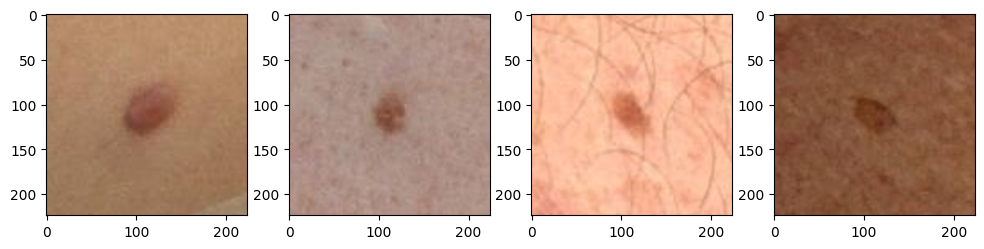

In [ ]:
images, labels, image_ids = load_images_and_labels('train-image.hdf5', train_benign_sample_ids, train_malignant_sample_ids, num_images=4)
nrows, ncols = 4, 4

fig = plt.gcf()
fig.set_size_inches(ncols * 3, nrows * 3)

for i, image in enumerate(images):
    plt.subplot(nrows, ncols, i + 1)
    plt.imshow(image)

plt.show()

## Defining the model

In this section we define our models for the detection.

We require a data generator due to the large size of the data.
The function is somewhat complex, and understanding the code may take time, so here's a brief overview:
We read the data sequentially from the file, and if we encounter a malignant image, we augment it to generate more.

In [ ]:
import itertools

def next_data_generator(benign_ids, malignant_ids, image_data_generator):
    ids = benign_ids + malignant_ids
    id_cycle = itertools.cycle(ids)

    while True:
        with h5py.File('train-image.hdf5', 'r') as f:
            img_id = next(id_cycle) # Get the next id from the cycle
            image_data = f[img_id][()]
            image = Image.open(io.BytesIO(image_data))
            image = image.resize((224, 224))
            image_array = np.array(image)

            if img_id in malignant_ids:
                augmented_image = image_array.copy()
                augmented_image = image_data_generator.random_transform(augmented_image)
                yield augmented_image, 1
            else:
                yield image_array / 255.0, 0

This is a wrapper function for the function called next_data_generator

In [ ]:
def data_generator(benign_ids, malignant_ids, image_data_generator, batch_size=32):
  get_next = next_data_generator(benign_ids, malignant_ids, image_data_generator)

  while True:
    batch_data = []
    batch_labels = []

    for _ in range(batch_size):
      image_array, label = next(get_next)
      batch_data.append(image_array)
      batch_labels.append(label)

    yield np.array(batch_data), np.array(batch_labels)

In this section I calculte the weight of the two given class.

In [ ]:
Y_train = [0] * len(train_benign_sample_ids) + [1] * len(train_malignant_sample_ids)
classes = np.unique(Y_train)
class_weights = compute_class_weight(class_weight='balanced', classes=classes, y=Y_train)
class_weight_dict = dict(zip(classes, class_weights))

In this code block, I define a custom loss function. This loss function weights the outputs based on the distribution of the minor and major classes. But it is still a binary crossentrphy loss function.

In [ ]:
def weighted_binary_crossentropy(y_true, y_pred):
  weights = tf.where(tf.equal(y_true, 1), class_weight_dict[1], class_weight_dict[0])
  weights = tf.cast(weights, dtype=tf.float32)
  loss = tf.keras.losses.binary_crossentropy(y_true, y_pred)
  weighted_loss = loss * weights
  return tf.reduce_mean(weighted_loss)

https://keras.io/examples/vision/image_classification_efficientnet_fine_tuning/

**Defining** the model for training.  
We use a **pretrained CNN** model for this assignment.  
We will try a few other models later, but this seems enough for now.  
What we will definitely have to do later is to experiment with **different loss functions and optimizers**.

In [ ]:
def build_model():
  model = EfficientNetV2B0(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
  model.trainable = False

  x = GlobalAveragePooling2D()(model.output)
  x = Dense(1024, activation='relu')(x)
  x = BatchNormalization()(x)
  x = Dropout(0.5)(x)
  x = Dense(512, activation='relu')(x)
  x = BatchNormalization()(x)
  x = Dropout(0.5)(x)
  output = Dense(1, activation='sigmoid')(x)

  model = Model(inputs=model.input, outputs=output)

  model.compile(optimizer=Adam(learning_rate=1e-4),
                loss=weighted_binary_crossentropy,
                metrics=['recall', 'precision'])
  return model

Here, I define the required callbacks.

In [ ]:
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True
)

reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.1,
    patience=3,
    min_lr=1e-6
)

**Training** the model.  
This might also be the subject of different **modifications** in the future.

In [ ]:
def cal_steps(num_images, batch_size):
   steps = num_images // batch_size
   return steps + 1 if (steps * batch_size) < num_images else steps

In [ ]:
batch_size = 32
epochs = 10

train_datagen = ImageDataGenerator(
      rescale=1./255,
      shear_range=0.2,
      zoom_range=0.2,
      horizontal_flip=True)

test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = data_generator(train_benign_sample_ids, train_malignant_sample_ids, train_datagen, batch_size)
validation_generator = data_generator(valid_benign_sample_ids, valid_malignant_sample_ids, test_datagen, batch_size)

steps_per_epoch = cal_steps(len(train_benign_sample_ids), batch_size)
validation_steps = cal_steps(len(valid_benign_sample_ids), batch_size)

print(validation_steps)
print(steps_per_epoch)


model = build_model()

hist = model.fit(
    train_generator,
    validation_data=validation_generator,
    epochs=epochs,
    verbose=2,
    batch_size=batch_size,
    steps_per_epoch=steps_per_epoch,
    validation_steps=validation_steps,
    callbacks=[reduce_lr, early_stopping]
)

Epoch 1/50
250/250 - 779s - 3s/step - loss: 0.7422 - precision: 0.0021 - recall: 0.8750 - val_loss: 0.1591 - val_precision: 1.0000 - val_recall: 1.0000 - learning_rate: 1.0000e-04
Epoch 2/50
250/250 - 0s - 789us/step - loss: 0.0000e+00 - precision: 0.0000e+00 - recall: 0.0000e+00 - learning_rate: 1.0000e-04
Epoch 3/50
250/250 - 40s - 159ms/step - loss: 0.0000e+00 - precision: 0.0000e+00 - recall: 0.0000e+00 - learning_rate: 1.0000e-04
Epoch 4/50
250/250 - 1s - 2ms/step - loss: 0.0000e+00 - precision: 0.0000e+00 - recall: 0.0000e+00 - learning_rate: 1.0000e-04
Epoch 5/50
250/250 - 0s - 2ms/step - loss: 0.0000e+00 - precision: 0.0000e+00 - recall: 0.0000e+00 - learning_rate: 1.0000e-04
Epoch 6/50
250/250 - 0s - 1ms/step - loss: 0.0000e+00 - precision: 0.0000e+00 - recall: 0.0000e+00 - learning_rate: 1.0000e-04
Epoch 7/50
250/250 - 0s - 885us/step - loss: 0.0000e+00 - precision: 0.0000e+00 - recall: 0.0000e+00 - learning_rate: 1.0000e-04
Epoch 8/50
250/250 - 0s - 1ms/step - loss: 0.0000e+

In [ ]:
def unfreeze_model(model):
    for layer in model.layers[-20:]:
        if not isinstance(layer, layers.BatchNormalization):
            layer.trainable = True

    model.compile(optimizer=Adam(learning_rate=1e-6),
                  loss=weighted_binary_crossentropy,
                  metrics=['recall', 'precision'])

In [ ]:
unfreeze_model(model)

epochs = 2

train_datagen = ImageDataGenerator(
      rescale=1./255,
      shear_range=0.2,
      zoom_range=0.2,
      horizontal_flip=True)

test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = data_generator(train_benign_sample_ids, train_malignant_sample_ids, train_datagen, batch_size)
validation_generator = data_generator(valid_benign_sample_ids, valid_malignant_sample_ids, test_datagen, batch_size)

steps_per_epoch = cal_steps(len(train_benign_sample_ids), batch_size)
validation_steps = cal_steps(len(valid_benign_sample_ids), batch_size)

hist = model.fit(
    train_generator,
    validation_data=validation_generator,
    epochs=epochs,
    verbose=2,
    batch_size=batch_size,
    steps_per_epoch=steps_per_epoch,
    validation_steps=validation_steps,
    callbacks=[reduce_lr, early_stopping]
)

Exception ignored in: <function WeakKeyDictionary.__init__.<locals>.remove at 0x7b8be68ff910>
Traceback (most recent call last):
  File "/usr/lib/python3.10/weakref.py", line 370, in remove
    def remove(k, selfref=ref(self)):
KeyboardInterrupt: 


Epoch 1/2


KeyboardInterrupt: 

Here we fill an aray with the **predictions** to simplify the code for the visualizations later.

In [ ]:
train_ids = test_benign_ids[:100] + test_malignant_ids
predictions_train = np.zeros((len(train_ids), 1))


for i, img_id in enumerate(train_ids):
  with h5py.File('train-image.hdf5', 'r') as f:
    image_data = f[img_id][()]
    image = Image.open(io.BytesIO(image_data)).resize((224, 224))
    image_array = tf.keras.preprocessing.image.img_to_array(image)
    image_array = np.expand_dims(image_array, axis=0)

    # Make prediction using the model
    prediction = model.predict(image_array, verbose=0)
    predictions_train[i] = prediction

# Now predictions_train contains the model's predictions for all train images
predictions_train.shape

(139, 1)

Plot the **confusion matrix**.  
It tells a lot about the model, very intuitively.

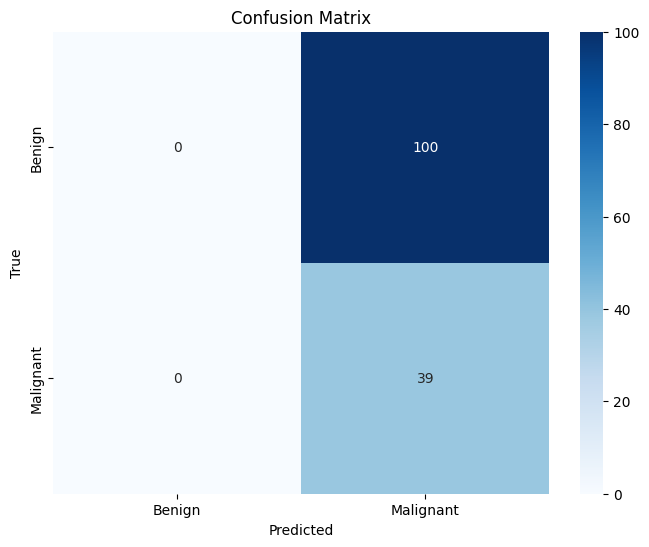

In [ ]:
import seaborn as sns
from sklearn.metrics import confusion_matrix

true_labels_train = [0] * 100 + [1] * len(test_malignant_ids)

# Convert predictions to binary (0 or 1) using a threshold (e.g., 0.5)
predicted_labels_train = (predictions_train > 0.5).astype(int)

# Calculate the confusion matrix
cm = confusion_matrix(true_labels_train, predicted_labels_train)

# Plot the confusion matrix using seaborn
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Benign', 'Malignant'], yticklabels=['Benign', 'Malignant'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

**Partial area under the ROC curve** (pAUC) above 80% true positive rate (TPR) for binary classification of malignant examples.

The receiver operating characteristic (ROC) curve illustrates the diagnostic ability of a given binary classifier system as its discrimination threshold is varied. However, there are regions in the ROC space where the values of TPR are unacceptable in clinical practice. Systems that aid in diagnosing cancers are required to be highly-sensitive, so this metric focuses on the area under the ROC curve AND above 80% TRP. Hence, scores range from [0.0, 0.2].

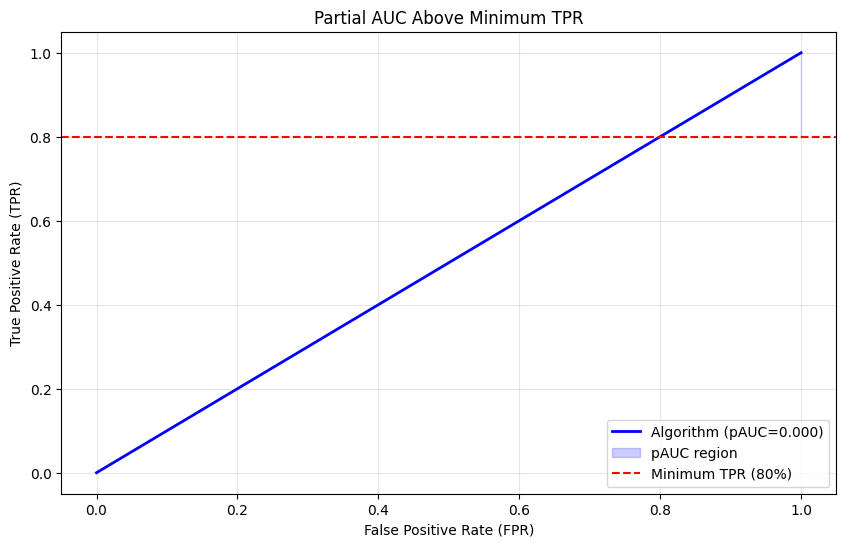

In [ ]:
from sklearn.metrics import roc_curve
from sklearn.metrics import auc

from sklearn.metrics import roc_curve
from sklearn.metrics import auc

def generate_pAUC_plot(algorithm_probs, true_labels, min_tpr=0.8):
    """
    Generate a plot pAUC above a given minimum TPR for algorithm.

    Parameters:
        algorithm_probs (list): Predicted probabilities from Algorithm.
        true_labels (list): Ground truth binary labels.
        min_tpr (float): Minimum TPR threshold for pAUC calculation (default=0.8).
    """

    # Compute ROC curves
    fpr_a, tpr_a, _ = roc_curve(true_labels, algorithm_probs)

    # Find index of TPR above the min_tpr
    min_tpr_idx_a = np.where(tpr_a >= min_tpr)[0]

    # Filter FPR and TPR above min_tpr for algorithm
    fpr_a_high_tpr, tpr_a_high_tpr = fpr_a[min_tpr_idx_a], tpr_a[min_tpr_idx_a]

    # Check if enough points exist to calculate AUC
    if len(fpr_a_high_tpr) < 2:
        print("Warning: Insufficient data points to calculate pAUC. Returning 0.")
        pAUC_a = 0.0
    else:
        # Calculate pAUC above min_tpr
        pAUC_a = auc(fpr_a_high_tpr, tpr_a_high_tpr)


    # Plot ROC curves
    plt.figure(figsize=(10, 6))
    plt.plot(fpr_a, tpr_a, label=f'Algorithm (pAUC={pAUC_a:.3f})', color='blue', linewidth=2)

    # Shade the pAUC region above min_tpr
    if len(fpr_a_high_tpr) > 0 : # check for valid points
        plt.fill_between(fpr_a_high_tpr, tpr_a_high_tpr, min_tpr, color='blue', alpha=0.2, label='pAUC region')

    # Add labels, legend, and grid
    plt.axhline(y=min_tpr, color='red', linestyle='--', label=f'Minimum TPR ({min_tpr*100:.0f}%)')
    plt.xlabel('False Positive Rate (FPR)')
    plt.ylabel('True Positive Rate (TPR)')
    plt.title('Partial AUC Above Minimum TPR')
    plt.legend(loc='lower right')
    plt.grid(alpha=0.3)
    plt.show()

generate_pAUC_plot(predictions_train, true_labels_train)

**Extra:**  
For the next assignment we will compare two approaches:  
- Gather new data from a different source to enhance the CNN.
- Use the metadata to enhance the decisions.  

These two might not be compatible, so we need to try and evaluate both.